Возьмем датасет с блогами. Достанем оттуда индекс, пол, возраст, текст сообщения и примерную длину сообщения. В каждом документе датасета несколько записей одного автора – возьмем самую длинную из них. Выберем такие блоги, где примерная длина – от 500 до 750 слов. Наберем таким образом 3000 записей.

In [89]:
import os
import pandas
import re


RE_TEXT = re.compile('<post>(.+?)</post>', flags=re.DOTALL)


data = pandas.DataFrame(columns=['id', 'sex', 'age', 'text', 'length'])


for root, dirs, files in os.walk('blogs'):
    for file_name in files:
        if file_name.endswith('.xml'):
            file_path = os.path.join(root, file_name)
            i, sex, age, industry, sign = file_name[:-4].split('.')
            with open(file_path, 'r', encoding='utf-8') as f:
                try:
                    texts = RE_TEXT.findall(f.read())
                    longest = max(texts, key=len)
                    words = longest.split()
                    if len(words) < 500 or len(words) > 750:
                        continue
                    data.loc[len(data)]=[i, sex, int(age), longest, len(words)]             
                    if len(data) == 3000:
                        break
                except UnicodeDecodeError:
                    continue
                
data.set_index(['id'], inplace=True)        
print(data.head())
print(data.describe())
            

            sex   age                                               text  \
id                                                                         
1005545    male  25.0  \n\n\t \n        Cell Phone company Thinks out...   
100812   female  26.0  \n\n\n\n\n       \n\n       Friday    My dear ...   
1019224  female  27.0  \n\n\t \n       Associated Press   Dallas - Th...   
1026443  female  15.0  \n\n    \n       Hello hello hello again. It's...   
1028257    male  26.0  \n\n\n       \n      Friday evening was a grea...   

         length  
id               
1005545   596.0  
100812    735.0  
1019224   592.0  
1026443   729.0  
1028257   565.0  
               age       length
count  3000.000000  3000.000000
mean     23.042000   616.815333
std       7.817924    73.176646
min      13.000000   500.000000
25%      16.000000   551.000000
50%      23.000000   613.000000
75%      26.000000   681.000000
max      48.000000   750.000000


Заменим пол на бинарную переменную.

In [93]:
new_sex = pandas.get_dummies(data['sex'], drop_first=True)
new_df = pandas.concat([data, new_sex], axis = 1)
new_df.drop(['sex'], axis=1, inplace=True)
new_df.head()

,age,text,length,male
id,,,,
1005545,25.0,\n\n\t \n Cell Phone company Thinks out...,596.0,1
100812,26.0,\n\n\n\n\n \n\n Friday My dear ...,735.0,0
1019224,27.0,\n\n\t \n Associated Press Dallas - Th...,592.0,0
1026443,15.0,\n\n \n Hello hello hello again. It's...,729.0,0
1028257,26.0,\n\n\n \n Friday evening was a grea...,565.0,1


Посмотрим, какие у нас получились значения и сбалансирована ли выборка.

In [94]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')


plt.subplot(1,3,1)
new_df.groupby('male').size().plot(kind='bar', figsize=(15,5))
plt.subplot(1,3,2)
new_df['age'].plot(kind='hist', bins=10).set_xlabel('age')
plt.subplot(1,3,3)
new_df['length'].plot(kind='hist', bins=10).set_xlabel('length')

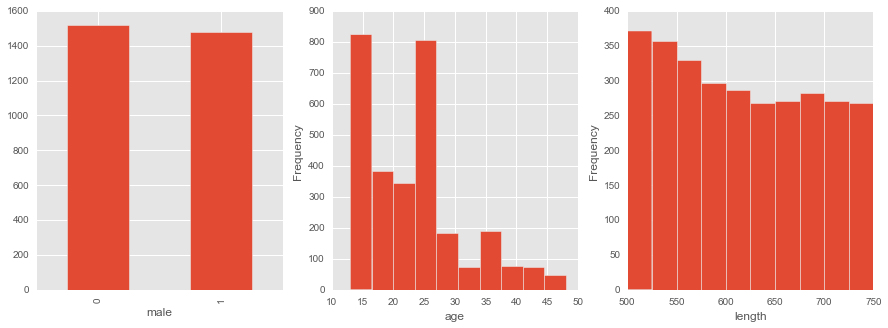

In [95]:
plt.show()

По полу выборка сбалансирована, по длинне текстов – более или менее, по возрасту полный раздрай. Но в описании датасета указано, что выборка сбалансирована по трем интервалам возрастов – teens, 20-somethings, 30-somethings. Понадеемся, что в нашей выборке этот баланс сохранился и поделим ее на три квантиля. Длину поделим на квантили, чтобы было удобнее смотреть на взаимодействие с возрастом и полом.

In [96]:
data['age'] = pandas.qcut(data['age'], 3, labels=[0, 1, 2])
data['length'] = pandas.qcut(data['length'], 3, labels=[0, 1, 2])
print(data.head())

            sex age                                               text length
id                                                                           
1005545    male   1  \n\n\t \n        Cell Phone company Thinks out...      1
100812   female   2  \n\n\n\n\n       \n\n       Friday    My dear ...      2
1019224  female   2  \n\n\t \n       Associated Press   Dallas - Th...      1
1026443  female   0  \n\n    \n       Hello hello hello again. It's...      2
1028257    male   2  \n\n\n       \n      Friday evening was a grea...      0


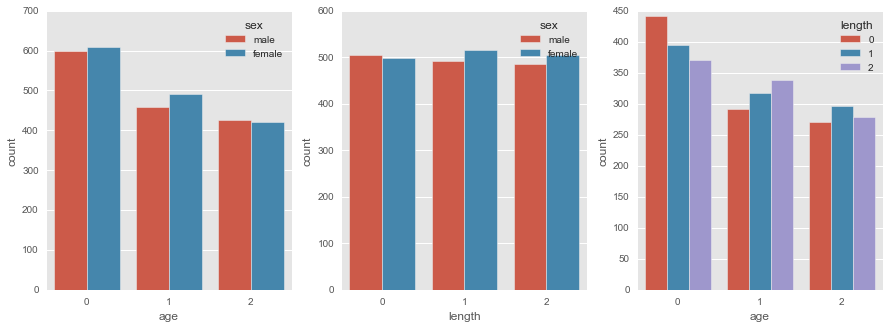

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
plt.subplot(1,3,1)
sns.countplot(x='age', hue='sex', data=data)
plt.subplot(1,3,2)
sns.countplot(x='length', hue='sex', data=data)
plt.subplot(1,3,3)
sns.countplot(x='age', hue='length', data=data)
plt.show()

Не совсем понимаю, как в первом квантиле по возрасту получилось больше народу (они вроде по определению должны быть одинаковые?). Но в общем и целом выборка более или менее сбалансирована – в каждой группе как минимум 250 текстов. Какое-то взаимодйствие можно предположить только с возрастом: там в более молодой группе преобладают короткие тексты, а в старших – средние и длинные. Хотя разница не сказать, что большая.

# Лемматизатор

In [98]:
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


wordnet_lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

text = data['text'].iloc[0]

def lemmatizer(string):
    words_pos = pos_tag(word_tokenize(string.lower()))
    words = [word for word in words_pos if word[0] not in '.,:;()!?-–"@#$%^&*+=[]{}\'']
    words = [(word[0].strip("'"), word[1]) for word in words]
    words = [(word[0], word[1]) for word in words if len(word[0]) > 1 and word[0] not in stopwords]
    words = [wordnet_lemmatizer.lemmatize(word[0], pos=get_wordnet_pos(word[1])) for word in words]
    return words
    

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN   

lemmatizer(text)[:10]

['cell',
 'phone',
 'company',
 'think',
 'box',
 'urllink',
 'news.com',
 'report',
 'manila',
 'philippine']

# CountVectorizer

Построим матрицу на биграммах. Возможно, бессмысленное занятие, но на триграммы/части речи времени уже нет. (На триграммах Random Forest работал больше часа, после чего я решила его пожалеть.)

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score


bow = CountVectorizer(tokenizer=lemmatizer, ngram_range=(2, 2), min_df=1)
bowed_text = bow.fit_transform(new_df['text'])

X_train, X_test, y_train, y_test = train_test_split(bowed_text, new_df['male'], test_size=0.2)

### Naive Bayes

In [100]:
naive = MultinomialNB()

cv_results = cross_val_score(naive, X_train, y_train, cv=10, scoring='accuracy')
print('Accuracy mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))
cv_results = cross_val_score(naive, X_train, y_train, cv=10, scoring='f1_weighted')
print('F1 mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))

Accuracy mean = 0.6066771992569315, sd = 0.021866522289392006
F1 mean = 0.5765165417948799, sd = 0.026017427801148248


Плохо.

### Random Forest

In [101]:
forest = RandomForestClassifier(n_estimators=50)

cv_results = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
print('Accuracy mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))
cv_results = cross_val_score(forest, X_train, y_train, cv=10, scoring='f1_weighted')
print('F1 mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))

Accuracy mean = 0.5774787756731887, sd = 0.021602019142936277
F1 mean = 0.5633708974290188, sd = 0.03378451997522899


Еще хуже. (А можно как-то сделать, чтобы cross_val_score считал сразу по двум метрикам – как здесь, по accuracy и F-мере? А то этот повтор увеличивает время работы в два раза :( )

### Logit

In [102]:
logit = LogisticRegression(class_weight='balanced')

cv_results = cross_val_score(logit, X_train, y_train, cv=10, scoring='accuracy')
print('Accuracy mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))
cv_results = cross_val_score(logit, X_train, y_train, cv=10, scoring='f1_weighted')
print('F1 mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))

Accuracy mean = 0.619979513533221, sd = 0.023213228911638496
F1 mean = 0.6186407627692599, sd = 0.022614453197139152


Совсем чуть-чуть получше.

### Logit на длине и возрасте для прикола

In [104]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_df[['age', 'length']], new_df['male'], test_size=0.2)

logit1 = LogisticRegression(class_weight='balanced')

cv_results = cross_val_score(logit1, X_train1, y_train1, cv=10, scoring='accuracy')
print('Accuracy mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))
cv_results = cross_val_score(logit1, X_train1, y_train1, cv=10, scoring='f1_weighted')
print('F1 mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))

Accuracy mean = 0.4799666660879529, sd = 0.03127053186860115
F1 mean = 0.4786662904828599, sd = 0.031230864248837562


Отвратительно. Больше такой штуки делать не будем.

Теперь всё то же самое сделаем для TfidfVectorizer.

# TfidfVectorizer

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer


bow = TfidfVectorizer(tokenizer=lemmatizer, ngram_range=(2, 2), min_df=1)
bowed_text = bow.fit_transform(new_df['text'])

X_train, X_test, y_train, y_test = train_test_split(bowed_text, new_df['male'], test_size=0.2)

naive = MultinomialNB()

cv_results = cross_val_score(naive, X_train, y_train, cv=10, scoring='accuracy')
print('Accuracy mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))
cv_results = cross_val_score(naive, X_train, y_train, cv=10, scoring='f1_weighted')
print('F1 mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))

forest = RandomForestClassifier(n_estimators=50)

cv_results = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
print('Accuracy mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))
cv_results = cross_val_score(forest, X_train, y_train, cv=10, scoring='f1_weighted')
print('F1 mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))

logit = LogisticRegression(class_weight='balanced')

cv_results = cross_val_score(logit, X_train, y_train, cv=10, scoring='accuracy')
print('Accuracy mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))
cv_results = cross_val_score(logit, X_train, y_train, cv=10, scoring='f1_weighted')
print('F1 mean = {}, sd = {}'.format(cv_results.mean(), cv_results.std()))

Accuracy mean = 0.5616532405076476, sd = 0.02054715393769805
F1 mean = 0.473646864287554, sd = 0.032314244339484335
Accuracy mean = 0.5774606981023978, sd = 0.04076940953917924
F1 mean = 0.5897756449714344, sd = 0.026110152158939744
Accuracy mean = 0.6329002601318312, sd = 0.03139683274084398
F1 mean = 0.6321817027761896, sd = 0.03134828721077613


Лучшую F-меру дала модель Logit на TfidfVectorizer (Accuracy mean = 0.63, F1 mean = 0.63), поэтому протестируем на ней тестовую выборку.

# Тестирование

In [108]:
logit.fit(X_train, y_train)
y = logit.predict(X_test)
print(metrics.classification_report(y_test, y))

             precision    recall  f1-score   support

          0       0.67      0.55      0.60       307
          1       0.60      0.72      0.66       293

avg / total       0.64      0.63      0.63       600



Те же самые 63%. У женщин немного больше точность, у мужчин – полнота. В целом чуть-чуть лучше определяются мужчины (66% против 60%).